# Shufflenet

### Model Imports

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import seaborn as sns
import glob as gb
import pandas as pd
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D ,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

### Parameters of Model

In [5]:
# Image and batch size
image_size = (96,96)
input_shape = (96, 96, 3) 
batch_size = 32
channels   = 3
epochs     = 20
LEARNING_RATE = 0.0005
input = 4

In [3]:
# Path to the dataset directory
dataset_path = r"D:\mp\EnableingDeepLearningOnLowCostDev\Competition\MaizeDiseaseImage_Classification_Dataset_Ghana"

# Define data augmentation and preprocessing for the images
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    validation_split=0.2        # Split dataset into 80% training and 20% validation
)

classes_required = ['Blight', 'Common_rust', 'Gray_leaf_spot', 'Healthy', 'Streak_virus']

# Generate batches of training dataset
train_generator = datagen.flow_from_directory(
    dataset_path,               # Path to the dataset directory
    target_size=image_size,     # Resize images to (96, 96)
    classes=classes_required,
    batch_size=batch_size,
    class_mode='categorical',   # For multiclass classification
    subset='training'           # Specify that this is the training set
)

# Generate batches of validation dataset
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    classes=classes_required,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'         # Specify that this is the validation set
)

# Get the class indices
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)


Found 15829 images belonging to 5 classes.
Found 3954 images belonging to 5 classes.
Class Indices: {'Blight': 0, 'Common_rust': 1, 'Gray_leaf_spot': 2, 'Healthy': 3, 'Streak_virus': 4}


### Build, Compile and Train the Model

In [6]:
def conv_bn_relu(x, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def depthwise_conv_bn(x, kernel_size, strides=(1, 1), padding='same'):
    x = DepthwiseConv2D(kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def ShuffleNetV2_model(weights='imagenet', input_shape=input_shape, include_top=False):
    input_img = Input(shape=input_shape)

    # Stage 1
    x = conv_bn_relu(input_img, filters=24, kernel_size=(3, 3), strides=(2, 2))

    # Stage 2
    x = depthwise_conv_bn(x, kernel_size=(3, 3), strides=(2, 2))
    x = conv_bn_relu(x, filters=48, kernel_size=(1, 1))

    # Stage 3
    x = depthwise_conv_bn(x, kernel_size=(3, 3), strides=(2, 2))
    x = conv_bn_relu(x, filters=96, kernel_size=(1, 1))

    # Global average pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    return model

# Create the model with 5 output classes
input_shape = (96, 96, 3) 
n_classes = 5
model = ShuffleNetV2_model(n_classes)


In [7]:
# Compile the model
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [6]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

In [8]:
# Train the model using generators
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size


# Record the time before training
start_time = time.time()

# Train the model using generators
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator,
    validation_steps=validation_steps, verbose=1
)

# Calculate the model train time
train_time = time.time() - start_time
print(f"Model Train Time: {train_time} seconds")

Epoch 1/20
494/494 [==============================] - 119s 237ms/step - loss: 0.5459 - accuracy: 0.8212 - val_loss: 1.4665 - val_accuracy: 0.4228
Epoch 2/20
494/494 [==============================] - 105s 212ms/step - loss: 0.2805 - accuracy: 0.9076 - val_loss: 0.4063 - val_accuracy: 0.8526
Epoch 3/20
494/494 [==============================] - 127s 256ms/step - loss: 0.2233 - accuracy: 0.9286 - val_loss: 0.2847 - val_accuracy: 0.9004
Epoch 4/20
494/494 [==============================] - 106s 215ms/step - loss: 0.1981 - accuracy: 0.9346 - val_loss: 0.3034 - val_accuracy: 0.8963
Epoch 5/20
494/494 [==============================] - 104s 211ms/step - loss: 0.1787 - accuracy: 0.9388 - val_loss: 0.2776 - val_accuracy: 0.8963
Epoch 6/20
494/494 [==============================] - 110s 222ms/step - loss: 0.1615 - accuracy: 0.9442 - val_loss: 0.3067 - val_accuracy: 0.8923
Epoch 7/20
494/494 [==============================] - 132s 268ms/step - loss: 0.1508 - accuracy: 0.9484 - val_loss: 0.1898 -

### Convert to tflite

In [9]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\fwulnye\AppData\Local\Temp\tmpvm9m073r\assets


INFO:tensorflow:Assets written to: C:\Users\fwulnye\AppData\Local\Temp\tmpvm9m073r\assets


87072

### Model testing

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

124/124 [==============================] - 18s 141ms/step - loss: 0.1868 - accuracy: 0.9345
Test Loss: 0.18683195114135742
Test Accuracy: 0.9344967007637024


### Graphs and Tables

In [11]:
# Get the predictions
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

124/124 [==============================] - 17s 134ms/step


In [12]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=-1))

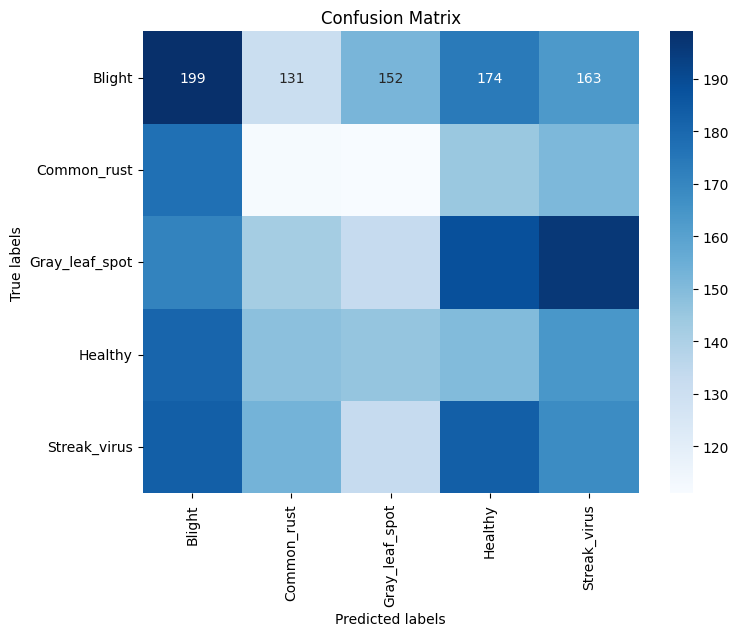

In [13]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes_required, yticklabels=classes_required)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Classification Report
report = classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=classes_required)
print("Classification Report:")
print(report)

Classification Report:
                precision    recall  f1-score   support

        Blight       0.22      0.24      0.23       819
   Common_rust       0.16      0.16      0.16       696
Gray_leaf_spot       0.20      0.16      0.18       830
       Healthy       0.18      0.19      0.18       789
  Streak_virus       0.20      0.20      0.20       820

      accuracy                           0.19      3954
     macro avg       0.19      0.19      0.19      3954
  weighted avg       0.19      0.19      0.19      3954



In [15]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

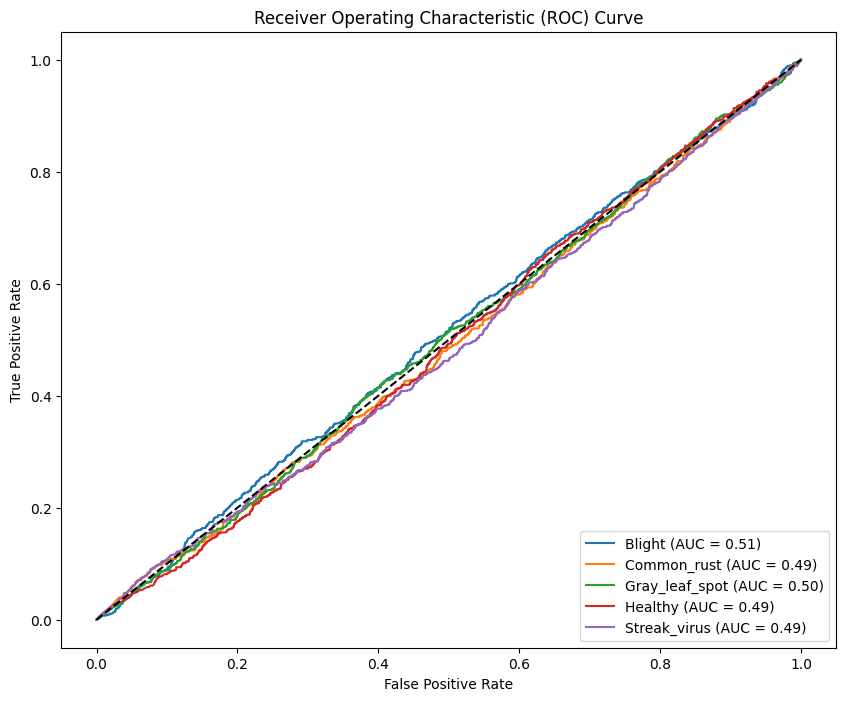

In [16]:
# Plot AUC-ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{classes_required[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

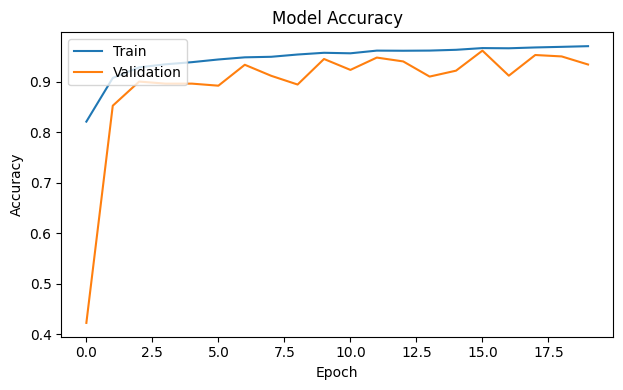

In [17]:
# Plotting the training history (accuracy and loss)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

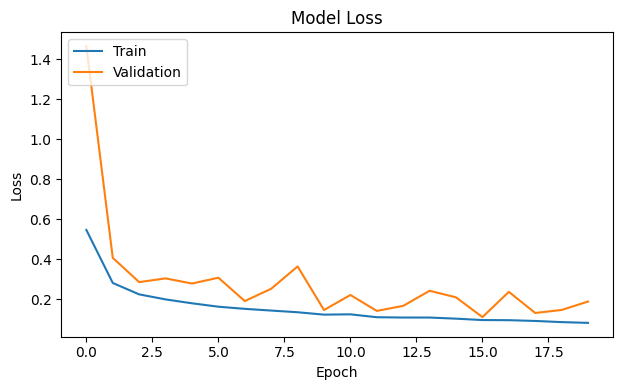

In [18]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Model Size, RAM and ROM

In [20]:
import os
import numpy as np
import tensorflow as tf

# Load the TFLite model
tflite_model_path = 'model.tflite'  # Path to your TFLite model file
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get the model size in bytes
model_size_bytes = os.path.getsize(tflite_model_path)

# Get model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Calculate RAM and ROM size
input_tensor_size_bytes = np.prod(input_details['shape']) * input_details['dtype'].itemsize
output_tensor_size_bytes = np.prod(output_details['shape']) * output_details['dtype'].itemsize

# ROM size is the size of the TFLite model file
rom_size_bytes = model_size_bytes

# RAM size includes input, output, and intermediate tensor sizes
ram_size_bytes = input_tensor_size_bytes + output_tensor_size_bytes

# Display the results
print(f"Model Size (ROM): {model_size_bytes} bytes")
print(f"RAM Size: {ram_size_bytes} bytes")
print(f"ROM Size: {rom_size_bytes} bytes")


TypeError: unsupported operand type(s) for *: 'int' and 'getset_descriptor'

## Model from Edge Impulse Platform